In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial

In [3]:
## Imports for plotting
import matplotlib.pyplot as plt

from transformers_multihead_attn_tutorial.data.reverse_dataset import ReverseDataset
from transformers_multihead_attn_tutorial.model.positional_encoding import PositionalEncoding
from transformers_multihead_attn_tutorial.model.scaled_dot_product import scaled_dot_product
from transformers_multihead_attn_tutorial.training.cosine_warmup_scheduler import CosineWarmupScheduler
from transformers_multihead_attn_tutorial.training.train_reverse import train_reverse

plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()


Device: cuda:0


In [4]:
## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms


In [5]:
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install pytorch-lightning==1.3.4
    import pytorch_lightning as pl


In [6]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



Global seed set to 42


In [7]:
## Scaled Dot Product Test

In [8]:
seq_len, d_k = 3, 2
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)

values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[ 0.5439, -0.0978],
        [ 0.5215, -0.0104],
        [ 0.2890,  0.4370]])
Attention
 tensor([[0.3819, 0.3017, 0.3163],
        [0.3478, 0.3145, 0.3377],
        [0.1759, 0.4309, 0.3932]])


In [9]:
## Visualizing Positional Encodings

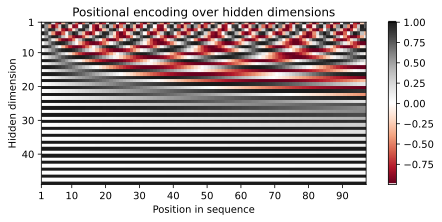

In [10]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

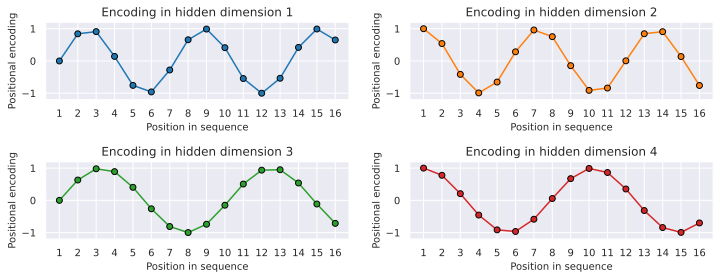

In [11]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color='C%i'%i, marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title("Encoding in hidden dimension %i" % (i+1))
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

In [12]:
## Cosine LR Scheduler Visualization

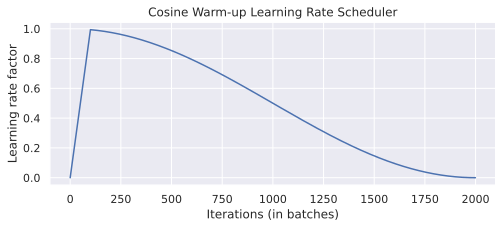

In [13]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In [14]:
## Dataset Creation

In [15]:
dataset = partial(ReverseDataset, 10, 16) # Very good partial usage
train_loader = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(1000), batch_size=128)
test_loader  = data.DataLoader(dataset(10000), batch_size=128)


In [16]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)


Input data: tensor([9, 6, 2, 0, 6, 2, 7, 9, 7, 3, 3, 4, 3, 7, 0, 9])
Labels:     tensor([9, 0, 7, 3, 4, 3, 3, 7, 9, 7, 2, 6, 0, 2, 6, 9])


In [23]:
reverse_model, reverse_result = train_reverse(model_name="ReverseTask",
                                              train_loader=train_loader,
                                              test_loader=test_loader,
                                              val_loader=val_loader,
                                              input_dim=train_loader.dataset.num_categories,
                                              model_dim=32,
                                              num_heads=2,
                                              num_classes=train_loader.dataset.num_categories,
                                              num_layers=1,
                                              dropout=0.0,
                                              lr=5e-4,
                                              warmup=50)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | input_net           | Sequential         | 352   
1 | positional_encoding | PositionalEncoding | 0     
2 | transformer         | TransformerEncoder | 8.5 K 
3 | output_net          | Sequential         | 1.4 K 
-----------------------------------------------------------
10.3 K    Trainable params
0         Non-trainable params
10.3 K    Total params
0.041     Total estimated model params size (MB)


/home/gsoykan20/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 42
/home/gsoykan20/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/gsoykan20/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [24]:
print("Val accuracy:  %4.2f%%" % (100.0 * reverse_result["val_acc"]))
print("Test accuracy: %4.2f%%" % (100.0 * reverse_result["test_acc"]))

Val accuracy:  98.90%
Test accuracy: 98.94%


In [25]:
# Attention Map Checking and Visualization

In [26]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=reverse_model.hparams.num_classes).float()
inp_data = inp_data.to(device)
attention_maps = reverse_model.get_attention_maps(inp_data)

In [27]:
attention_maps[0].shape


torch.Size([128, 2, 16, 16])

In [28]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title("Layer %i, Head %i" % (row+1, column+1))
    fig.subplots_adjust(hspace=0.5)
    plt.show()


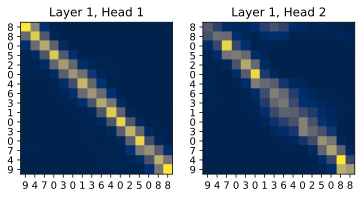

In [29]:
plot_attention_maps(data_input, attention_maps, idx=0)
